In [11]:
LAMBDA = 100000
EPOCHS = 10

In [2]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

In [4]:
training_dataset, validation_dataset = tfds.load(
    "cifar10",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)
print(len(training_dataset), len(validation_dataset))

40000 10000


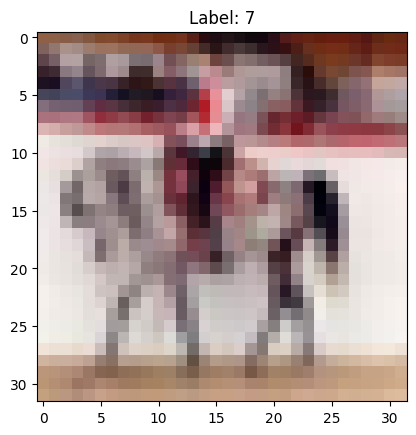

In [5]:
for image, label in training_dataset.take(1):
    # Display the image
    plt.imshow(image)
    plt.title(f"Label: {label.numpy()}")
    plt.show()

In [35]:
PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

LATENT_SIZE = 8*8*50

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
  ], name="analysis_transform")
  return encoder

LATENT_SIZE = 32*32*50

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
  ], name="analysis_transform")
  return encoder

In [36]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          3200, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          51200, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((32, 32, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((8, 8, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((32, 32, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

In [37]:
class CompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor."""

  def __init__(self, latent_dims=LATENT_SIZE):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 32, 32, 3))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per image.
    rate = tf.reduce_mean(rate)

    # Divide rate by the number of neurons in the latent space. This normalizes the rate in bits/neuron.
    rate /= tf.cast(tf.shape(y)[1], dtype=tf.float32)

    # Mean absolute difference across pixels.
    #distortion = tf.reduce_mean(abs(x - x_tilde))
    distortion = tf.sqrt(tf.reduce_mean((x - x_tilde)*(x - x_tilde))) # RMSE
    #distortion = tf.reduce_mean((x - x_tilde)*(x - x_tilde))
    #tf.print(rate, distortion)

    return dict(rate=rate, distortion=distortion)

In [38]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_compression_trainer(lmbda, latent_dims=LATENT_SIZE):
  trainer = CompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

In [39]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_model(lmbda=LAMBDA, epochs=EPOCHS):
  trainer = make_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=epochs,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer

trainer = train_model(lmbda=LAMBDA)
trainer.analysis_transform.summary()
trainer.synthesis_transform.summary()

Epoch 1/10
312/313 [============================>.] - ETA: 0s - loss: 10705.4121 - distortion_loss: 0.1070 - rate_loss: 1.9655 - distortion_pass_through_loss: 0.1070 - rate_pass_through_loss: 1.9655

313/313 [==============================] - 16s 44ms/step - loss: 10698.8789 - distortion_loss: 0.1070 - rate_loss: 1.9653 - distortion_pass_through_loss: 0.1069 - rate_pass_through_loss: 1.9651 - val_loss: 8801.3672 - val_distortion_loss: 0.0880 - val_rate_loss: 1.8176 - val_distortion_pass_through_loss: 0.0880 - val_rate_pass_through_loss: 1.8179
Epoch 2/10
313/313 [==============================] - 13s 42ms/step - loss: 5661.0806 - distortion_loss: 0.0566 - rate_loss: 1.7146 - distortion_pass_through_loss: 0.0566 - rate_pass_through_loss: 1.7144 - val_loss: 6777.3794 - val_distortion_loss: 0.0678 - val_rate_loss: 1.5643 - val_distortion_pass_through_loss: 0.0678 - val_rate_pass_through_loss: 1.5646
Epoch 3/10
313/313 [==============================] - 14s 45ms/step - loss: 4621.4458 - distortion_loss: 0.0462 - rate_loss: 1.5234 - distortion_pass_through_loss: 0.0462 - rate_pass_through_loss: 1.5233 - val_loss: 5436.8267 - val_distortion_loss: 0.0544 - val_rate_loss: 1.3860 - val_dist

In [40]:
class Compressor(tf.keras.Model):
  """Compresses images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

In [41]:
class Decompressor(tf.keras.Model):
  """Decompresses images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

In [42]:
def make_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = Compressor(trainer.analysis_transform, entropy_model)
  decompressor = Decompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_codec(trainer)

String representation of first digit in hexadecimal: 0xdc8f07447b9e0b7a676e2df39e156314c0bab802581d818e998161896011c705759d07a0ef39d31edf411fe421e3bbb894e02ee53b2880cdd6a9ce527afe8b937d663e4bed10784c0858caeecbe746e1d3bd8cf88c1898ee7971b125aa7cf392f6de24b560cf25d7555e0313c6271d697581d900f53fc842677e53ed18128adfce5025c5173643f2018d42801970bed7ff313c2e5c744e3e7789bace3590487d3c84fb058f837311ff5354cf759738261fcacedd8f8a62204811fbe85b046d41b706136275ddec3e50d7f9a9f27a83d580144405829323844d71f0de8899294e9acb8223a4243f46e52801a5dffed57f943587d459e35a4483f0678eb5b8f93c2834cd0903e9794145118d7d8db60bcadaae1a78fc2b7a9549090207ff2429b65b28bce504f9e6acf4500e56780973fe11f8cc7ab355208758d00b3d83e23c59dcdf197e91030e422add105cc1649ba717e5f21e2a9e8f9ea3580c61d053ec07bd18f9514cd2e1c695d024123a9bbe618daff10bcce0b9a92e6a3d9636596110dd0fd80c716dec7db35c0006c75b03e1346c5ba9cdeb4eef1d34343e49d2e962378b858952377ecbcf17977a32b6c960c812f1667f15a34e53e036216022f8738eeeaa48105f28f1b0630af94e7a9a4ea08892b97ff240ab6

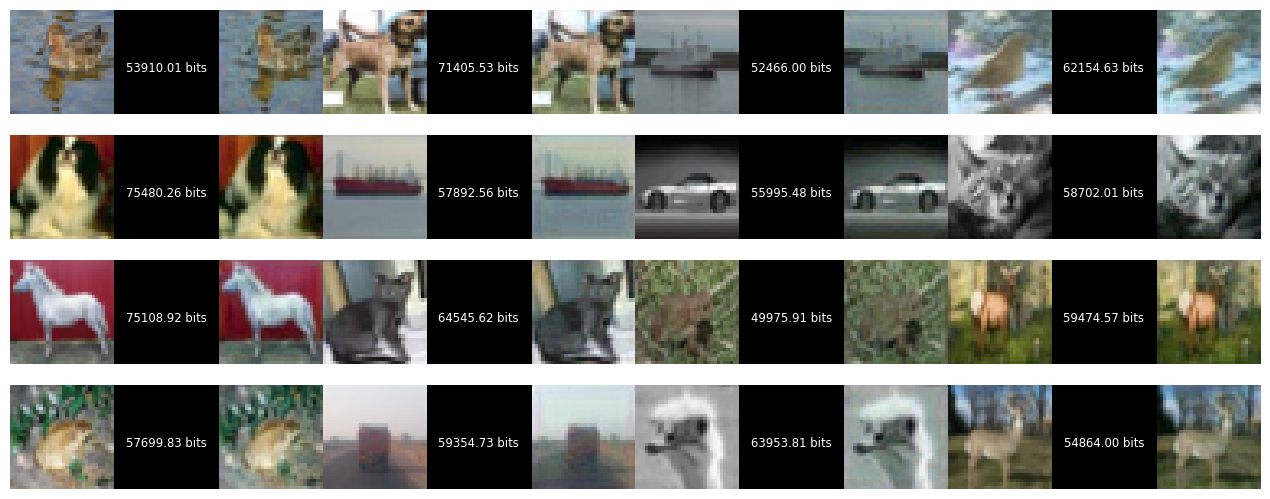

In [54]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)
strings, entropies = compressor(originals)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")

reconstructions = decompressor(strings)

def display_images(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((32, 32, 3), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        #.5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        .5, .5, f"{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

display_images(originals, strings, entropies, reconstructions)


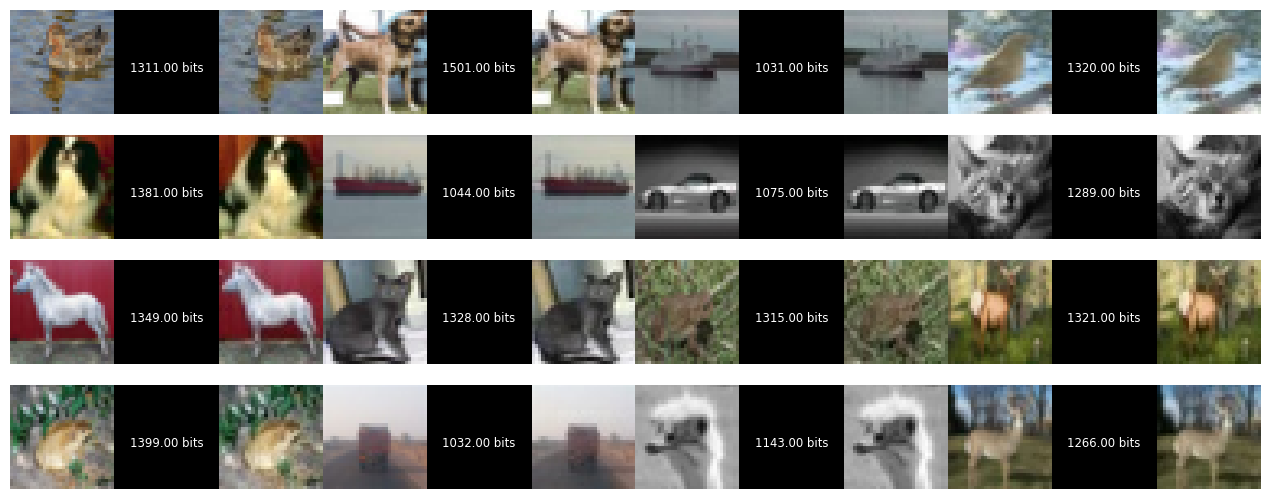

In [58]:
# Compare with JPEG

(originals, _), = validation_dataset.batch(16).skip(3).take(1)

reconstructions = []
entropies = []
for i in originals:
  j = tf.image.encode_jpeg(i)
  k = tf.image.decode_jpeg(j)
  reconstructions.append(k)
  length_j = tf.strings.length(j)
  entropies.append(length_j)

display_images(originals, strings, entropies, reconstructions)